<h4>Setup & Load Results</h4>

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

plt.style.use('ggplot')

try:
    with open('../results/deduplicated_contacts.json', 'r') as f:
        clean_data = json.load(f)
    with open('../results/deduplication_stats.json', 'r') as f:
        stats = json.load(f)
    with open('../results/evaluation_results.json', 'r') as f:
        metrics = json.load(f)
        
    print(f"Loaded {len(clean_data)} unique entitites.")
    print(f"Loaded metrics (F1 Score: {metrics['f1_score']:.1%})")
except FileNotFoundError:
    print(f"Error: Result files not found. Please run pipeline.py first.")

Loaded 65 unique entitites.
Loaded metrics (F1 Score: 96.1%)


<h4>ROI Dashboard</h4>

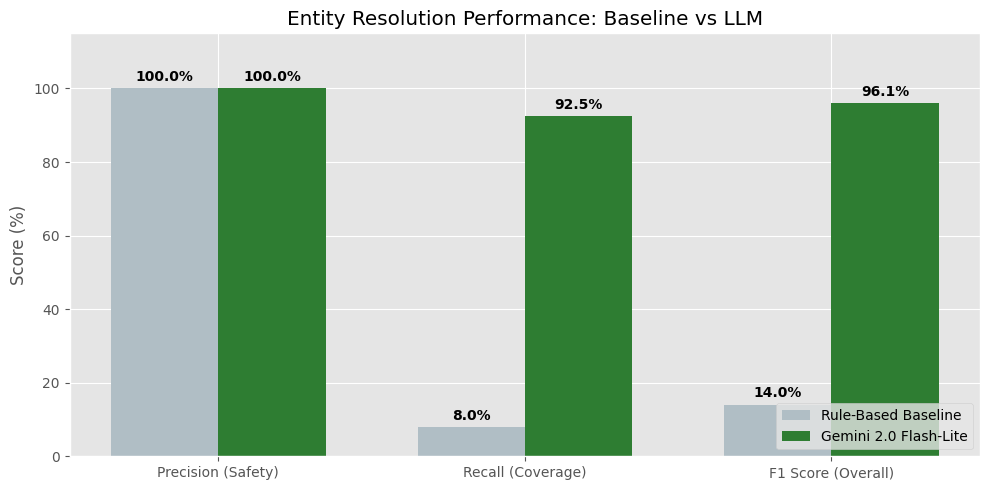

In [2]:
labels = ['Precision (Safety)', 'Recall (Coverage)', 'F1 Score (Overall)']
baseline_scores = [100.0, 8.0, 14.04]
llm_scores = [metrics['precision']*100, metrics['recall']*100, metrics['f1_score']*100]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar([i - width/2 for i in x], baseline_scores, width, label='Rule-Based Baseline', color='#B0BEC5')
rects2 = ax.bar([i + width/2 for i in x], llm_scores, width, label='Gemini 2.0 Flash-Lite', color='#2E7D32')

ax.set_ylabel('Score (%)')
ax.set_title('Entity Resolution Performance: Baseline vs LLM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower right')
ax.set_ylim(0, 115)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

<h4>Macro View</h4>

Building graph for 65 unique entities.


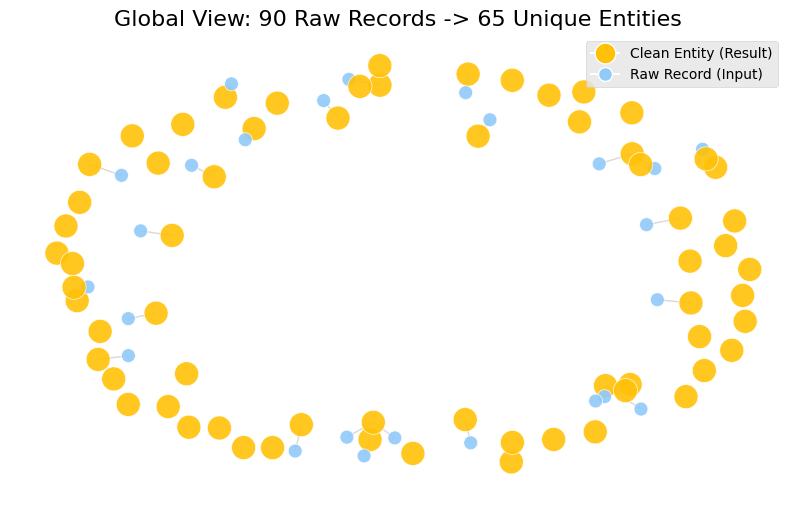

In [15]:
G_full = nx.Graph()
color_map = []
size_map = []

print(f"Building graph for {len(clean_data)} unique entities.")

for entity in clean_data:
    center_id = entity.get('canonical_id') or entity.get('id')
    
    if not center_id:
        continue
    
    G_full.add_node(center_id, type='canonical')
    
    if 'source_records' in entity:
        for source in entity['source_records']:
            source_id = source['id']
            if source_id != center_id:
                G_full.add_node(source_id, type='source')
                G_full.add_edge(center_id, source_id)
            
for node in G_full.nodes(data=True):
    if node[1]['type'] == 'canonical':
        color_map.append('#FFC107')  # Blue for canonical
        size_map.append(300)
    else:
        color_map.append('#90CAF9')  # Light blue for source
        size_map.append(100)
        
plt.figure(figsize=(10, 6))

pos = nx.spring_layout(G_full, k=0.2, iterations=50, seed=42)

nx.draw_networkx_nodes(G_full, pos, node_color=color_map, node_size=size_map, alpha=0.9, edgecolors='white')
nx.draw_networkx_edges(G_full, pos, alpha=0.3, edge_color='grey')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clean Entity (Result)', markerfacecolor='#FFC107', markersize=15),
    Line2D([0], [0], marker='o', color='w', label='Raw Record (Input)', markerfacecolor='#90CAF9', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Global View: 90 Raw Records -> {len(clean_data)} Unique Entities", fontsize=16)
plt.axis('off')
plt.show()

<h4>Micro View</h4>

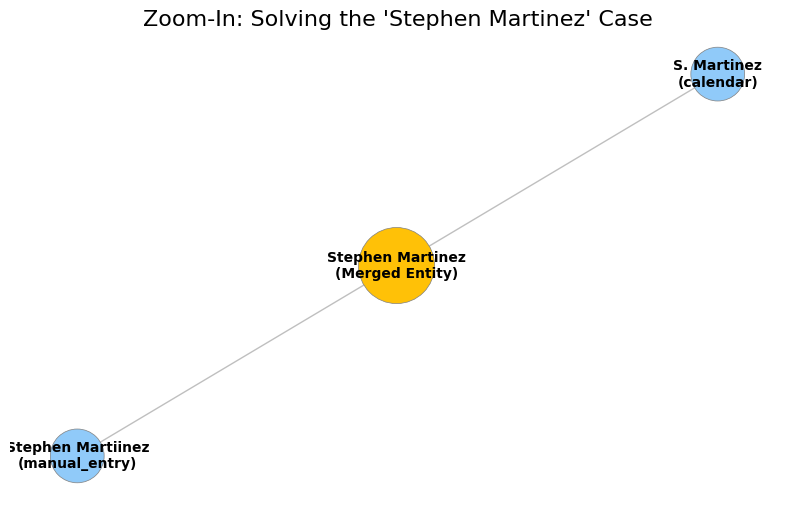

In [23]:
complex_clusters = sorted(
    [d for d in clean_data if len(d.get('source_records', [])) > 1],
    key = lambda x: len(x.get('source_records', [])),
    reverse=True
)

if complex_clusters:
    target = complex_clusters[0]
    
    center_id = target.get('canonical_id') or target.get('id')
    center_name = target.get('canonical_name', 'Unknown Entity')
    
    G_zoom = nx.Graph()
    center_label = f"{center_name}\n(Merged Entity)"
    
    G_zoom.add_node(center_id, label=center_label, color='#FFC107', size=3000)
    
    for i, source in enumerate(target['source_records']):
        full_name = source.get('full_name', 'Unknown')
        src_type = source.get('source', 'unknown')
        source_id = source.get('id', f"lead_{i}")
        
        if source_id != center_id:
            label = f"{full_name}\n({src_type})"
            
            G_zoom.add_node(source_id, label=label, color='#90CAF9', size=1500)
            G_zoom.add_edge(center_id, source_id)
        
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G_zoom, k=0.5, seed=42)
    
    colors = [nx.get_node_attributes(G_zoom, 'color')[node] for node in G_zoom.nodes()]
    sizes = [nx.get_node_attributes(G_zoom, 'size')[node] for node in G_zoom.nodes()]
    labels = nx.get_node_attributes(G_zoom, 'label')
    
    nx.draw_networkx_nodes(G_zoom, pos, node_color=colors, node_size=sizes, edgecolors='grey')
    nx.draw_networkx_edges(G_zoom, pos, alpha=0.5, edge_color='grey')
    
    nx.draw_networkx_labels(G_zoom, pos, labels, font_size=10, font_weight='bold')
    
    plt.title(f"Zoom-In: Solving the '{center_name}' Case", fontsize=16)
    plt.axis('off')
    plt.show()
    
else:
    print("No complex clusters found. The system was very strict, so no merges occurred to visualize.")

<h4>Audit Trail (Data Proof)</h4>

In [28]:
from IPython.display import display, HTML

if 'target' not in locals():
    complex_clusters = sorted(
        [d for d in clean_data if len(d.get('source_records', [])) > 1],
        key = lambda x: len(x.get('source_records', [])),
        reverse=True
    )
    if complex_clusters:
        target = complex_clusters[0]
        
if 'target' in locals():
    center_name = target.get('canonical_name', 'Unknown')
    center_id = target.get('canonical_id') or target.get('id')
    
    raw_ts = target.get('merge_timestamp', 'N/A')
    clean_ts = raw_ts.split('.')[0].replace('T', ' ') if isinstance(raw_ts, str) else raw_ts
    
    print(f"Provenance Report: {center_name}")
    print(f"Canonical ID: {center_id}")
    print(f"Merge Timestamp : {clean_ts}")
    print("-" * 40)
    
    df = pd.DataFrame(target['source_records'])
    
    cols = ['id', 'full_name', 'email', 'company', 'source']
    available_cols = [col for col in cols if col in df.columns]
    
    display(df[available_cols].style.set_properties(**{'text-align': 'left'}))
    
    print(f"\n Results: {len(target['source_records'])} raw records merged into 1 unique entity.")
    
else:
    print("No merged records to display.")

Provenance Report: Stephen Martinez
Canonical ID: base_1_2
Merge Timestamp : 2025-12-05 14:50:47
----------------------------------------


,id,full_name,email,company,source
0,base_1_2,Stephen Martinez,nan,Garcia-James,nan
1,base_1_2_v2,S. Martinez,nan,Garcia-James,calendar
2,base_1_2_v1,Stephen Martiinez,stephen.martiinez@garcia-james.com,Garcia-James,manual_entry



 Results: 3 raw records merged into 1 unique entity.


<h4>Search Tool</h4>

In [33]:
SEARCH_NAME = "Douglas"

print(f"Searching for entities related to name: {SEARCH_NAME}...")

found = []
for entity in clean_data:
    c_name = entity.get('canonical_name', entity.get('full_name', ''))
    
    s_name = [r.get('full_name', '') for r in entity.get('source_records', [])]
    
    if SEARCH_NAME.lower() in c_name.lower() or any(SEARCH_NAME.lower() in name.lower() for name in s_name):
        found.append(entity)
        
if found:
    print(f"Found {len(found)} matches:\n")
    
    for f in found:
        c_id = f.get('canonical_id') or f.get('id')
        name = f.get('canonical_name', f.get('full_name'))
        is_merged = len(f.get('source_records', [])) > 1
        status = "MERGED" if is_merged else "SINGLETON"
        
        print(f"[{status}] {name} (ID: {c_id})")
else:
    print("No matches found.")

Searching for entities related to name: Douglas...
Found 2 matches:

[MERGED] Douglas Taylor (ID: base_2_3)
[SINGLETON] Douglas Taylor (ID: base_2_3_v1)
